Импорты

In [276]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import glob
import matplotlib.pyplot as plt 


Инструменты для загрузки картинок

In [277]:

def load():
    path = "/content/*.*"
    """Загрузка картинок без обрезания"""
    return [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob(path))]

def split(img):
    """Разбиение картинок на маленькие"""
    size = 10
    img_height = img.shape[0] // size
    img_width = img.shape[1] // size
    res = []
    for i in range(size):
        for j in range(size):
            res.append(img[i * img_height:(i+1) * img_height, j * img_width:(j+1) * img_width])
    return res

def squeeze(split_img):
    """Сжатие 32 на 32"""
    return cv2.resize(split_img, (32, 32))

def img_to1d(img):
    """Трансформация к 1 мерному"""
    return img.ravel()

def normalize(img):
    """Нормализация каждого пикселя к отрезку [0, 1]"""
    return img / 255.0

def process_img(img):
    """Обработка исходной картинка"""
    return (squeeze(img))

def img_to1d(img):
    """Трансформация к 1 мерному"""
    return img.ravel()

Загрузим картинки

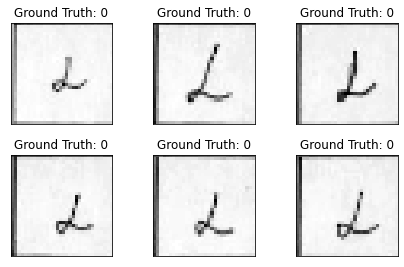

In [278]:
labels = np.array([0]*300+[1]*300+[2]*300+[3]*300+[4]*300)
src_imgs = load()
label = 0
features = []
for img in src_imgs:
    split_imgs = split(img)
    for split_img in split_imgs:
        features.append(process_img(split_img))
data_set = features

fig = plt.figure()
for i in range(0,6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(data_set[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

for i in range(0, len(data_set)):
    data_set[i] = normalize(data_set[i])

А теперь будем разбивать на тестовую выборку и на обучающую.  

In [279]:
x_train, x_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.33, random_state=42)
x_train[0]

array([[0.98431373, 0.97254902, 0.98039216, ..., 0.98823529, 0.45098039,
        0.83529412],
       [0.96078431, 0.98431373, 0.96862745, ..., 0.94509804, 0.43529412,
        0.89019608],
       [0.98039216, 0.96470588, 0.97647059, ..., 0.98823529, 0.45882353,
        0.88235294],
       ...,
       [0.96078431, 0.97254902, 0.96078431, ..., 0.95686275, 0.40784314,
        0.96078431],
       [0.77254902, 0.78823529, 0.81176471, ..., 0.94117647, 0.4       ,
        0.90588235],
       [0.81960784, 0.81960784, 0.81568627, ..., 0.72156863, 0.70980392,
        0.71372549]])

Берем датасет 

In [280]:
# Model / data parameters
num_classes = 5
input_shape = (32, 32, 1)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# # convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1005, 32, 32, 1)
1005 train samples
495 test samples


Теперь создаем нейросетку и треним ее

In [281]:

#Сверточная сеть
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model1.summary()

# Полносвязная сеть многослойная
model2 =  keras.Sequential([
  keras.Input(shape=1024),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])

model2.summary()

# Полносвязная сеть однослойная
model3 =  keras.Sequential([
  keras.Input(shape=1024),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])

model3.summary()


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2304)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 5)               

Теперь будем тренировать convolutional нейросеть

In [282]:
batch_size = 128
epochs = 80

model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/80
8/8 [==============================] - 2s 144ms/step - loss: 1.6134 - accuracy: 0.2091 - val_loss: 1.6055 - val_accuracy: 0.2178
Epoch 2/80
8/8 [==============================] - 1s 122ms/step - loss: 1.6087 - accuracy: 0.2046 - val_loss: 1.6026 - val_accuracy: 0.2079
Epoch 3/80
8/8 [==============================] - 1s 120ms/step - loss: 1.6082 - accuracy: 0.2080 - val_loss: 1.6007 - val_accuracy: 0.2178
Epoch 4/80
8/8 [==============================] - 1s 117ms/step - loss: 1.6034 - accuracy: 0.2080 - val_loss: 1.5970 - val_accuracy: 0.2178
Epoch 5/80
8/8 [==============================] - 1s 121ms/step - loss: 1.5981 - accuracy: 0.2246 - val_loss: 1.5912 - val_accuracy: 0.2178
Epoch 6/80
8/8 [==============================] - 1s 120ms/step - loss: 1.5902 - accuracy: 0.2743 - val_loss: 1.5828 - val_accuracy: 0.4356
Epoch 7/80
8/8 [==============================] - 1s 120ms/step - loss: 1.5807 - accuracy: 0.3042 - val_loss: 1.5729 - val_accuracy: 0.4554
Epoch 8/80
8/8 [====

Проверяем convolutional нейросеть:

In [283]:
score = model1.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3456214666366577
Test accuracy: 0.9070706963539124


Будем тренировать многослойную полносвязную нейросеть

In [284]:
batch_size = 128
epochs = 400

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
x_train1 = x_train.reshape(int(1500*0.67),1024)
model2.fit(x_train1, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/400
8/8 [==============================] - 1s 27ms/step - loss: 1.7730 - accuracy: 0.2013 - val_loss: 1.6216 - val_accuracy: 0.2178
Epoch 2/400
8/8 [==============================] - 0s 7ms/step - loss: 1.6934 - accuracy: 0.1991 - val_loss: 1.5962 - val_accuracy: 0.2574
Epoch 3/400
8/8 [==============================] - 0s 6ms/step - loss: 1.6223 - accuracy: 0.2279 - val_loss: 1.6225 - val_accuracy: 0.2277
Epoch 4/400
8/8 [==============================] - 0s 8ms/step - loss: 1.6093 - accuracy: 0.2356 - val_loss: 1.5804 - val_accuracy: 0.3663
Epoch 5/400
8/8 [==============================] - 0s 8ms/step - loss: 1.5979 - accuracy: 0.2677 - val_loss: 1.5804 - val_accuracy: 0.2079
Epoch 6/400
8/8 [==============================] - 0s 7ms/step - loss: 1.5866 - accuracy: 0.2566 - val_loss: 1.5743 - val_accuracy: 0.4059
Epoch 7/400
8/8 [==============================] - 0s 7ms/step - loss: 1.5797 - accuracy: 0.3440 - val_loss: 1.5854 - val_accuracy: 0.1782
Epoch 8/400
8/8 [=========

Теперь оценим точность многослойной:

In [285]:


score = model2.evaluate(x_test.reshape(int(1500*0.33),1024), y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.7627102732658386
Test accuracy: 0.7010101079940796


Теперь поработаем с однослойной сетью. Потренируем ее:

In [286]:
batch_size = 128
epochs = 400

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
x_train1 = x_train.reshape(int(1500*0.67),1024)
model3.fit(x_train1, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/400
8/8 [==============================] - 1s 29ms/step - loss: 2.0194 - accuracy: 0.2035 - val_loss: 1.6483 - val_accuracy: 0.2871
Epoch 2/400
8/8 [==============================] - 0s 8ms/step - loss: 1.6886 - accuracy: 0.2235 - val_loss: 1.6280 - val_accuracy: 0.1881
Epoch 3/400
8/8 [==============================] - 0s 10ms/step - loss: 1.6328 - accuracy: 0.1947 - val_loss: 1.5992 - val_accuracy: 0.2079
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 1.6022 - accuracy: 0.2367 - val_loss: 1.5877 - val_accuracy: 0.2673
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 1.5929 - accuracy: 0.2577 - val_loss: 1.5747 - val_accuracy: 0.2475
Epoch 6/400
8/8 [==============================] - 0s 7ms/step - loss: 1.5815 - accuracy: 0.2666 - val_loss: 1.5611 - val_accuracy: 0.4257
Epoch 7/400
8/8 [==============================] - 0s 6ms/step - loss: 1.5816 - accuracy: 0.2412 - val_loss: 1.5703 - val_accuracy: 0.2178
Epoch 8/400
8/8 [========

Оценим ее точность: 

In [287]:

score = model3.evaluate(x_test.reshape(int(1500*0.33),1024), y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9052936434745789
Test accuracy: 0.6565656661987305
